In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, RandomSampler
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import time
import os  
import sys
import copy
import pandas as pd
import visdom
import random
import matplotlib.image as mpimg 
import warnings
warnings.filterwarnings("ignore")
import nrrd
import shutil
from datetime import datetime
from tensorboardX import SummaryWriter


import src.dataloader
import src.train3d


## Create Dataset and DataLoader

In [29]:
import src.dataloader
import importlib
importlib.reload(src.dataloader)

augmentor =  transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1, 1).permute(3, 0, 1, 2)),
    src.dataloader.Resize(256), 
])
    

path = '/data/larson2/RCC_dl/new/clear_cell'
train_ds = src.dataloader.RCCDataset_h5(path, mode='train', transform=augmentor)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, drop_last=False)

val_ds = src.dataloader.RCCDataset_h5(path, mode='val', transform=augmentor)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=4, drop_last=False)



print(train_ds[0][0].shape)
print(val_ds[0][0].shape)



torch.Size([18, 3, 256, 256])
torch.Size([17, 3, 256, 256])


### Preview Image

/data/larson2/RCC_dl/new/clear_cell/train/pt727.hdf5


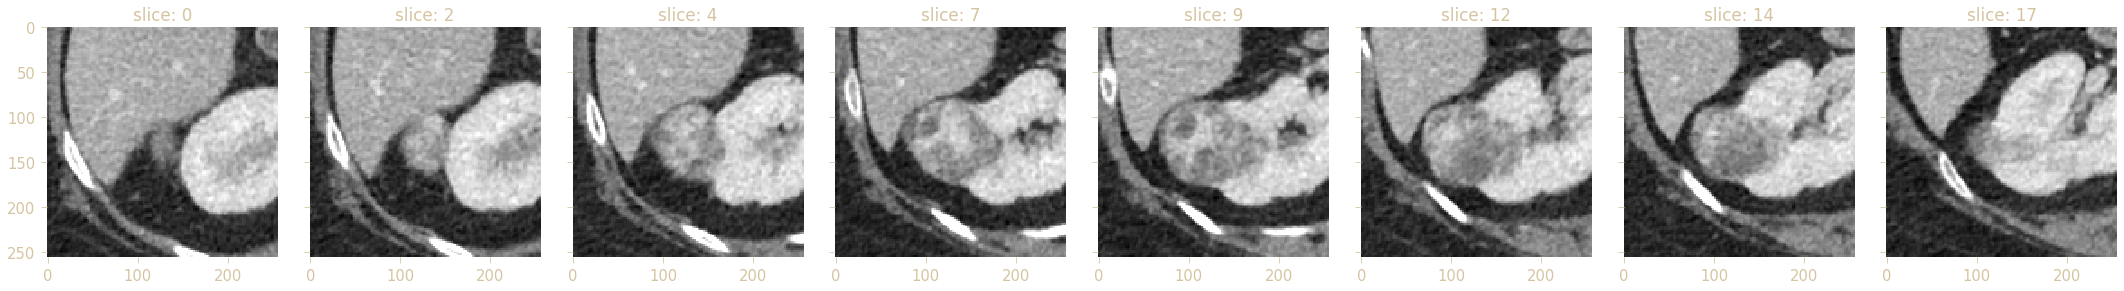

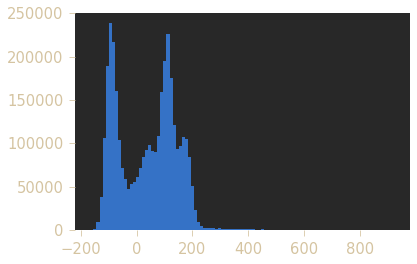

In [6]:
array = train_ds[0][0]
num_im = array.shape[0]
list_show = np.linspace(0, num_im-1, 8)

fig, axes = plt.subplots(ncols=8, nrows=1, figsize=(30, 4), sharex=True, sharey=True)
for index, i in enumerate(list_show):
    slice_num = int(i)
    im = array[slice_num, 0, :,:].squeeze()
#     im = array[:,:,slice_num].squeeze()


    axes[index].imshow(im, vmin=-160, vmax=240, cmap=plt.cm.gray)
    axes[index].set_title('slice: {}'.format(slice_num))
#     fig.suptitle('TITLE')
    fig.tight_layout()
    fig.subplots_adjust(top = 0.9, bottom=0.1)
#     plt.colorbar()
plt.show()
plt.hist(array.flatten(), 100)
plt.show()

## Training

### Parameters

In [33]:
device = torch.device("cpu")
prefix_name='test_cpu'
# task='abnormal'
# plane='sagittal'
augment=1
lr_scheduler='plateau'
gamma=0.8
epochs=25
lr=1e-4
flush_history=0
save_model=1
patience=25
log_every=25


log_root_folder = "/data/larson2/RCC_dl/logs/"
now = datetime.now()
logdir = log_root_folder + "test"
# logdir = log_root_folder + now.strftime("%Y%m%d-%H%M%S") + "/"
# os.makedirs(logdir)

model_root_dir = "/data/larson2/RCC_dl/models/"

writer = SummaryWriter(logdir)
         

### Initialize 

#### resnet

In [ ]:
model = models.alexnet(pretrained=True)
# print(list(list(model.classifier.children())[1].parameters()))
mod = list(model.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(4096, 2))
new_classifier = torch.nn.Sequential(*mod)
# print(list(list(new_classifier.children())[1].parameters()))
model.classifier = new_classifier
model.classifier
# m.classifier

In [42]:
model = models.alexnet(pretrained=True)
# print(list(list(model.classifier.children())[1].parameters()))
mod = list(model.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(4096, 2))
new_classifier = torch.nn.Sequential(*mod)
# print(list(list(new_classifier.children())[1].parameters()))
model.classifier = new_classifier
model
# m.classifier

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [56]:
list(model.classifier.children()).pop()

Linear(in_features=4096, out_features=2, bias=True)

#### mrnet

In [34]:
mrnet = src.model.MRNet()
mrnet = mrnet.to(device)
optimizer = optim.Adam(mrnet.parameters(), lr=lr, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=gamma)

best_val_loss = float('inf')
best_val_auc = float(0)

num_epochs = epochs
iteration_change_loss = 0
patience = patience
log_every = log_every
t_start_training = time.time()

In [50]:
mrnet.classifier

AttributeError: 'MRNet' object has no attribute 'classifier'

### Train

In [36]:
for epoch in range(epochs):
    current_lr = src.train3d.get_lr(optimizer)

    t_start = time.time()

    train_loss, train_auc = src.train3d.train_model(
        mrnet, train_loader, device, epoch, num_epochs, optimizer, writer, current_lr, log_every)
    val_loss, val_auc = src.train3d.evaluate_model(
        mrnet, val_loader, device, epoch, num_epochs, writer, current_lr)


    if lr_scheduler == 'plateau':
        scheduler.step(val_loss)
    elif lr_scheduler == 'step':
        scheduler.step()

    t_end = time.time()
    delta = t_end - t_start

    print("train loss : {0} | train auc {1} | val loss {2} | val auc {3} | elapsed time {4} s".format(
        train_loss, train_auc, val_loss, val_auc, delta))

    iteration_change_loss += 1
    print('-' * 30)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        if bool(save_model):
            file_name = f'model_{prefix_name}_val_auc_{val_auc:0.4f}_train_auc_{train_auc:0.4f}_epoch_{epoch+1}.pth'
            for f in os.listdir(model_root_dir):
                if  (prefix_name in f):
                    os.remove(os.path.join(model_root_dir, f))
            torch.save(mrnet, os.path.join(model_root_dir, file_name))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        iteration_change_loss = 0

    if iteration_change_loss == patience:
        print('Early stopping after {0} iterations without the decrease of the val loss'.
              format(iteration_change_loss))
        break

t_end_training = time.time()
print(f'training took {t_end_training - t_start_training} s')

in train, weight =  1
[Epoch: 1 / 25 |Single batch number : 25 / 292 ]| avg train loss 0.8637 | train auc : 0.6242 | lr : 0.0001
[Epoch: 1 / 25 |Single batch number : 50 / 292 ]| avg train loss 0.8033 | train auc : 0.5476 | lr : 0.0001
[Epoch: 1 / 25 |Single batch number : 75 / 292 ]| avg train loss 0.7543 | train auc : 0.5397 | lr : 0.0001
[Epoch: 1 / 25 |Single batch number : 100 / 292 ]| avg train loss 0.752 | train auc : 0.5437 | lr : 0.0001
[Epoch: 1 / 25 |Single batch number : 125 / 292 ]| avg train loss 0.7513 | train auc : 0.5562 | lr : 0.0001
[Epoch: 1 / 25 |Single batch number : 150 / 292 ]| avg train loss 0.7545 | train auc : 0.5367 | lr : 0.0001
[Epoch: 1 / 25 |Single batch number : 175 / 292 ]| avg train loss 0.7244 | train auc : 0.5527 | lr : 0.0001
[Epoch: 1 / 25 |Single batch number : 200 / 292 ]| avg train loss 0.7152 | train auc : 0.5533 | lr : 0.0001
[Epoch: 1 / 25 |Single batch number : 225 / 292 ]| avg train loss 0.724 | train auc : 0.5705 | lr : 0.0001
[Epoch: 1 /

[Epoch: 5 / 25 |Single batch number : 225 / 292 ]| avg train loss 0.4246 | train auc : 0.8828 | lr : 0.0001
[Epoch: 5 / 25 |Single batch number : 250 / 292 ]| avg train loss 0.4641 | train auc : 0.8508 | lr : 0.0001
[Epoch: 5 / 25 |Single batch number : 275 / 292 ]| avg train loss 0.495 | train auc : 0.8178 | lr : 0.0001
p/t     1     0
  1     51    19
  0     44    178
sens: 0.5368
spec: 0.9036
acc:  0.7842

[Epoch: 5 / 25 |Single batch number : 20 / 65 ] | avg val loss 0.7426 | val auc : 0.85 | lr : 0.0001
[Epoch: 5 / 25 |Single batch number : 40 / 65 ] | avg val loss 0.7179 | val auc : 0.6149 | lr : 0.0001
[Epoch: 5 / 25 |Single batch number : 60 / 65 ] | avg val loss 0.6876 | val auc : 0.5791 | lr : 0.0001
p/t     1     0
  1     4    24
  0     6    31
sens: 0.4000
spec: 0.5636
acc:  0.5385

train loss : 0.5093 | train auc 0.8107 | val loss 0.6946 | val auc 0.5909 | elapsed time 63.052889347076416 s
------------------------------


NameError: name 'task' is not defined